useful links:

- Data Preparation for Variable Length Input Sequences, URL: https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/
- Masking and padding with Keras, URL: https://www.tensorflow.org/guide/keras/masking_and_padding
- Step-by-step understanding LSTM Autoencoder layers, URL: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352XX, 
- Understanding input_shape parameter in LSTM with Keras, URL: https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
- tf.convert_to_tensor, URL: https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
- ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) in Python, URL: https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type

In [1]:
"""
* Copyright 2020, Maestria de Humanidades Digitales,
* Universidad de Los Andes
*
* Developed for the Msc graduation project in Digital Humanities
*
* This program is free software: you can redistribute it and/or modify
* it under the terms of the GNU General Public License as published by
* the Free Software Foundation, either version 3 of the License, or
* (at your option) any later version.
*
* This program is distributed in the hope that it will be useful,
* but WITHOUT ANY WARRANTY; without even the implied warranty of
* MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
* GNU General Public License for more details.
*
* You should have received a copy of the GNU General Public License
* along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# ===============================
# native python libraries
# ===============================
import re
import random
import json
import csv
import cv2
import datetime
import gc
from collections import OrderedDict
from collections import Counter
from collections import deque

# ===============================
# extension python libraries
# ===============================
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt

# natural language processing packages
import gensim
from gensim import models
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# downloading nlkt data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# sample handling sklearn package
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain

# # Keras + Tensorflow ML libraries
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

# ===============================
# developed python libraries
# ===============================

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

taken from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
'''
def temporalize(data, lookback):
    output_X = list()
    for i in range(len(X)-lookback-1):
        temp = list()
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            temp.append(data[[(i+j+1)], :])
        temp = np.array(temp, dtype="object")
        output_X.append(temp)
    output_X = np.array(output_X, dtype="object")
    return output_X

In [3]:
def read_img(img_fpn):
    ans = cv2.imread(img_fpn, cv2.IMREAD_UNCHANGED)
    return ans

In [4]:
# fuction to scale the image and reduce cv2
def scale_img(img, scale_pct):

    width = int(img.shape[1]*scale_pct/100)
    height = int(img.shape[0]*scale_pct/100)
    dim = (width, height)
    # resize image
    ans = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return ans

In [5]:
def std_img(img, minv, maxv):
    rangev = maxv - minv
    ans = img.astype("float32")/float(rangev)
    # ans = pd.Series(ans)
    # respuesta de la funcion
    return ans

In [6]:
def pad_img(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(np.uint16)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(np.uint16)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(np.uint16)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(np.uint16)
    ans = np.copy(np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode="constant", constant_values=0))
    return ans

In [7]:
def update_shape(src_df, img_col, shape_col):

    ans = src_df
    src_col = list(ans[img_col])
    tgt_col = list()

    # ansdict = {}
    for data in src_col:
        tshape = data.shape
        tgt_col.append(tshape)

    ans[shape_col] = tgt_col
    return ans

In [8]:
# function to load the images in in memory
def get_images(rootf, src_df, src_col, tgt_col, scale_pct):
    ans = src_df
    src_files = list(ans[src_col])
    tgt_files = list()

    # ansdict = {}
    for tfile in src_files:
        tfpn = os.path.join(rootf, tfile)
        timg = read_img(tfpn)
        timg = scale_img(timg, scale_pct)
        tgt_files.append(timg)

    ans[tgt_col] = tgt_files
    return ans

In [9]:
def padding_images(src_df, src_col, tgt_col, max_shape):
    ans = src_df
    src_images = list(ans[src_col])
    tgt_images = list()
    max_x, max_y = max_shape[0], max_shape[1]
    padding = None

    # ansdict = {}
    for timg in src_images:
        # print(timg)
        timg = np.array(timg, dtype="object")
        # std_timg = std_img(timg, 0, 255)
        pimg = pad_img(timg, max_y, max_x)
        tgt_images.append(pimg)

    ans[tgt_col] = tgt_images
    return ans

In [10]:
def standarize_images(src_df, src_col, tgt_col):
    ans = src_df
    src_images = list(ans[src_col])
    tgt_images = list()

    # ansdict = {}
    for timg in src_images:
        # print(timg)
        timg = np.array(timg, dtype="object")
        std_timg = std_img(timg, 0, 255)
        tgt_images.append(std_timg)

    ans[tgt_col] = tgt_images
    return ans

In [11]:
# function to get the max shape in the image dataset
def get_mshape(shape_data, imgt):

    max_x, max_y, max_ch = 0, 0, 0
    shape_data = list(shape_data)
    ans = None

    if imgt == "rgb":

        for tshape in shape_data:
            if type(tshape) is str:
                tshape = eval(tshape)
            tx, ty, tch = tshape[0], tshape[1], tshape[2]

            if tx > max_x:
                max_x = tx
            if ty > max_y:
                max_y = ty
            if tch > max_ch:
                max_ch = tch
            
        ans = (max_x, max_y, max_ch)
    
    elif imgt == "bw":

        for tshape in shape_data:
            tshape = eval(tshape)
            tx, ty = tshape[0], tshape[1]

            if tx > max_x:
                max_x = tx
            if ty > max_y:
                max_y = ty
            
        ans = (max_x, max_y)
        
    return ans

In [12]:
# variable definitions
# root folder
dataf = "Data"

# subfolder with predictions txt data
imagef = "Img"

# report subfolder
reportf = "Reports"

#  subfolder with the CSV files containing the ML pandas dataframe
stdf = "Train"

testf = "Test"

# dataframe file extension
fext = "csv"

imgf = "jpg"

rgb_sufix = "rgb"
bw_sufix = "bw"

# standard sufix
stdprefix = "std-"

# ml model useful data
mltprefix = "ml-"

# report names
str_date = datetime.date.today().strftime("%d-%b-%Y")

small_sufix = "Img-Data-Small"
large_sufix = "Img-Data-Large"
painting_sufix = "Img-Data-Paintings"

gallery_prefix = "VVG-Gallery"

# dataframe file name
small_fn = stdprefix + gallery_prefix + "-" + small_sufix + "." + fext
large_fn = stdprefix + gallery_prefix + "-" + large_sufix + "." + fext
painting_fn = stdprefix + gallery_prefix + "-" + painting_sufix + "." + fext

# ramdom seed
randseed = 42

# sample distribution train vs test sample size
trainf = 0.80
testf = 1 - trainf

# regex to know that column Im interested in
keeper_regex = r"(^ID$)|(^std_)"

imgt = rgb_sufix

# default values
# work_fn, work_sufix, work_imgt = small_fn, small_sufix, rgb_sufix
# work_fn, work_sufix, work_imgt = painting_fn, painting_sufix, imgt
work_fn, work_sufix, work_imgt = large_fn, large_sufix, rgb_sufix

In [13]:
root_folder = os.getcwd()
root_folder = os.path.split(root_folder)[0]
root_folder = os.path.normpath(root_folder)
print(root_folder)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer


In [14]:
# variable reading
# dataframe filepath
fn_path = os.path.join(root_folder, dataf, stdf, work_fn)
print(fn_path)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Train\std-VVG-Gallery-Img-Data-Large.csv


In [15]:
# rading training data
# loading file
source_df = pd.read_csv(
                fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )

In [16]:
# checking everything is allrigth
source_df.head(5)
# chekcing the dataframe
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     929 non-null    object
 1   F-number               929 non-null    object
 2   JH-number              929 non-null    object
 3   Dimensions             929 non-null    object
 4   creator-place          929 non-null    object
 5   creator-date           828 non-null    object
 6   details                929 non-null    object
 7   rgb_img                929 non-null    object
 8   bw_img                 929 non-null    object
 9   rgb_shape              929 non-null    object
 10  bw_shape               929 non-null    object
 11  std_cat_creator-date   929 non-null    object
 12  std_cat_creator-place  929 non-null    object
 13  std_cat_Dimensions     929 non-null    object
 14  std_cat_details        929 non-null    object
dtypes: object(15)
memory us

In [17]:
# reading images from folder and loading images into df
# working variables
src_col = work_imgt + "_img"
tgt_col = work_imgt + "_img" + "_data"
work_shape = work_imgt + "_shape"

scale = 16 # !!! 50->400pix, 64->512pix, 32->256pix 16->128pix
print(src_col, tgt_col)
source_df = get_images(root_folder, source_df, src_col, tgt_col, scale)

rgb_img rgb_img_data


In [18]:
# update image shape
source_df = update_shape(source_df, tgt_col, work_shape)

In [19]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     929 non-null    object
 1   F-number               929 non-null    object
 2   JH-number              929 non-null    object
 3   Dimensions             929 non-null    object
 4   creator-place          929 non-null    object
 5   creator-date           828 non-null    object
 6   details                929 non-null    object
 7   rgb_img                929 non-null    object
 8   bw_img                 929 non-null    object
 9   rgb_shape              929 non-null    object
 10  bw_shape               929 non-null    object
 11  std_cat_creator-date   929 non-null    object
 12  std_cat_creator-place  929 non-null    object
 13  std_cat_Dimensions     929 non-null    object
 14  std_cat_details        929 non-null    object
 15  rgb_img_data           

In [20]:
# searching the biggest shape in the image files
print(work_shape)
shape_data = source_df[work_shape]
print(type(shape_data[0]))
max_shape = get_mshape(shape_data, work_imgt)
print(max_shape)

rgb_shape
<class 'tuple'>
(128, 128, 3)


In [21]:
# padding training data according to max shape of the images in gallery
pad_prefix = "pad_"
conv_prefix = "cnn_"
src_col = work_imgt + "_img" + "_data"
tgt_col = pad_prefix + conv_prefix + src_col

print(src_col, tgt_col)
source_df = padding_images(source_df, src_col, tgt_col, max_shape)

rgb_img_data pad_cnn_rgb_img_data


In [22]:
source_df.info()
# test = source_df["pad_cnn_rgb_img_data"].value_counts()
# print(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     929 non-null    object
 1   F-number               929 non-null    object
 2   JH-number              929 non-null    object
 3   Dimensions             929 non-null    object
 4   creator-place          929 non-null    object
 5   creator-date           828 non-null    object
 6   details                929 non-null    object
 7   rgb_img                929 non-null    object
 8   bw_img                 929 non-null    object
 9   rgb_shape              929 non-null    object
 10  bw_shape               929 non-null    object
 11  std_cat_creator-date   929 non-null    object
 12  std_cat_creator-place  929 non-null    object
 13  std_cat_Dimensions     929 non-null    object
 14  std_cat_details        929 non-null    object
 15  rgb_img_data           

In [23]:
# reading images from folder and stadarizing images into df
# working variables
print("standarizing regular images...")
src_col = work_imgt + "_img" + "_data"
tgt_col = "std_" + src_col

source_df = standarize_images(source_df, src_col, tgt_col)

standarizing regular images...


In [24]:
print("standarizing padded images...")
src_col = pad_prefix + conv_prefix + work_imgt + "_img" + "_data"
tgt_col = "std_" + src_col

source_df = standarize_images(source_df, src_col, tgt_col)

standarizing padded images...


In [25]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        929 non-null    object
 1   F-number                  929 non-null    object
 2   JH-number                 929 non-null    object
 3   Dimensions                929 non-null    object
 4   creator-place             929 non-null    object
 5   creator-date              828 non-null    object
 6   details                   929 non-null    object
 7   rgb_img                   929 non-null    object
 8   bw_img                    929 non-null    object
 9   rgb_shape                 929 non-null    object
 10  bw_shape                  929 non-null    object
 11  std_cat_creator-date      929 non-null    object
 12  std_cat_creator-place     929 non-null    object
 13  std_cat_Dimensions        929 non-null    object
 14  std_cat_details           

In [26]:
# selecting data to train
gc.collect()

97

In [27]:
# function to find a name of column names according to a regex
def get_keeper_cols(col_names, search_regex):
    ans = [i for i in col_names if re.search(search_regex, i)]
    return ans

In [28]:
# function to find the disperse columns in the df
def get_disperse_categories(src_df, keep_cols, max_dis, check_cols, ignore_col):

    ans = list()

    max_dis = 2
    tcount = 0

    while tcount < max_dis:
        for label_col in keep_columns:

            if label_col != ignore_col:

                label_count = src_df[label_col].value_counts(normalize=False)

                if tcount < label_count.shape[0] and (check_cols in label_col):
                    tcount = label_count.shape[0]
                    ans.append(label_col)
                # print("count values of", label_col, ":=", label_count.shape)#.__dict__)
        tcount = tcount + 1
    
    return ans

In [29]:
# function to remove the disperse columns from the interesting ones
def remove_disperse_categories(keep_columns, too_disperse):
    for too in too_disperse:
        keep_columns.remove(too)
    return keep_columns

In [30]:
# selecting data to train
# want to keep the columns starting with STD_
keep_columns = list(source_df.columns)
print("------ original input/interested columns ------")
print(keep_columns)

# create the columns Im interesting in
keep_columns = get_keeper_cols(keep_columns, keeper_regex)
# keep_columns = [i for i in df_columns if re.search(keeper_regex, i)]

print("\n\n------ Interesting columns ------")
print(keep_columns)

------ original input/interested columns ------
['ID', 'F-number', 'JH-number', 'Dimensions', 'creator-place', 'creator-date', 'details', 'rgb_img', 'bw_img', 'rgb_shape', 'bw_shape', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'rgb_img_data', 'pad_cnn_rgb_img_data', 'std_rgb_img_data', 'std_pad_cnn_rgb_img_data']


------ Interesting columns ------
['ID', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'std_rgb_img_data', 'std_pad_cnn_rgb_img_data']


In [31]:
too_disperse = get_disperse_categories(source_df, keep_columns, 2, "std_cat_", "std_pad_cnn_rgb_img_data")
print(too_disperse)

['std_cat_creator-date', 'std_cat_Dimensions']


In [32]:
# creating the training dataframe
keep_columns = remove_disperse_categories(keep_columns, too_disperse)
# keep_columns.remove("ID")
print("------ Interesting columns ------")
print(keep_columns)

------ Interesting columns ------
['ID', 'std_cat_creator-place', 'std_cat_details', 'std_rgb_img_data', 'std_pad_cnn_rgb_img_data']


In [33]:
# checking the number of max num on labels in the categories
too_disperse = list()
max_dis = 2
tcount = 0

while tcount < max_dis:
    for label_col in keep_columns:
        label_count = source_df[label_col].value_counts(normalize=False)

        if tcount < label_count.shape[0] and ("std_cat_" in label_col):
            tcount = label_count.shape[0]
            too_disperse.append(label_col)

        print("count values of", label_col, ":=", label_count.shape)#.__dict__)
    tcount = tcount + 1

print(too_disperse)

count values of ID := (929,)
count values of std_cat_creator-place := (21,)
count values of std_cat_details := (113,)
count values of std_rgb_img_data := (929,)
count values of std_pad_cnn_rgb_img_data := (929,)
['std_cat_creator-place', 'std_cat_details']


In [34]:
# creating the training dataframe
print("------ Interesting columns ------")
print(keep_columns)
train_df = pd.DataFrame(source_df, columns=keep_columns)

------ Interesting columns ------
['ID', 'std_cat_creator-place', 'std_cat_details', 'std_rgb_img_data', 'std_pad_cnn_rgb_img_data']


In [35]:
# checking the train dataframe
train_df.info()
source_df = None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        929 non-null    object
 1   std_cat_creator-place     929 non-null    object
 2   std_cat_details           929 non-null    object
 3   std_rgb_img_data          929 non-null    object
 4   std_pad_cnn_rgb_img_data  929 non-null    object
dtypes: object(5)
memory usage: 36.4+ KB


In [36]:
regular_img_col = "std_" + work_imgt + "_img" + "_data"
padded_img_col = "std_" + pad_prefix + conv_prefix + work_imgt + "_img" + "_data"

In [37]:
# funct to concatenate all label columns into one for a single y in ML training, returns a list
def concat_labels(row, cname):
    ans = list()
    for c in cname:

        r = row[c]
        r = eval(r)
        ans = ans + r

    return ans

In [38]:
def heat_categories(train_df, cat_cols, tgt_col):

    labels_data = train_df[cat_cols]
    labels_concat = list()

    # concatenating all category labels from dataframe
    for index, row in labels_data.iterrows():
        row = concat_labels(row, labels_cols)
        labels_concat.append(row)

    # print(len(labels_concat[0]), type(labels_concat[0]))
    # updating dataframe
    tcat_label_col = "std_cat_labels"
    train_df[tgt_col] = labels_concat

    return train_df

In [39]:
# getting the columns with the relevant labels to predict
print(keep_columns)
labels_cols = [i for i in keep_columns if re.search(u"^std_cat_", i)]
print("Trainable labels columns in dataframe: ", str(labels_cols))

labels_data = train_df[labels_cols]
labels_concat = list()

# concatenating all category labels from dataframe
for index, row in labels_data.iterrows():
    row = concat_labels(row, labels_cols)
    labels_concat.append(row)

['ID', 'std_cat_creator-place', 'std_cat_details', 'std_rgb_img_data', 'std_pad_cnn_rgb_img_data']
Trainable labels columns in dataframe:  ['std_cat_creator-place', 'std_cat_details']


In [40]:
print(len(labels_concat[0]), type(labels_concat[0]))

134 <class 'list'>


In [41]:
# updating dataframe
tcat_label_col = "std_cat_labels"
train_df[tcat_label_col] = labels_concat

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        929 non-null    object
 1   std_cat_creator-place     929 non-null    object
 2   std_cat_details           929 non-null    object
 3   std_rgb_img_data          929 non-null    object
 4   std_pad_cnn_rgb_img_data  929 non-null    object
 5   std_cat_labels            929 non-null    object
dtypes: object(6)
memory usage: 43.7+ KB


In [43]:
working_img_col = padded_img_col
# working_img_col = regular_img_col

In [44]:
# selecting data to train
gc.collect()

75

In [45]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
og_shape = train_df[working_img_col][0].shape# y[0].shape
X_img_len = train_df[working_img_col].shape[0] #y.shape[0]
print(X_img_len, og_shape)

X = None

for img in train_df[working_img_col]:

    if X is None:
        img = np.expand_dims(img, axis=0)
        X = img
    else:
        img = np.expand_dims(img, axis=0)
        X = np.concatenate((X, img), axis=0)

print("final X_img shape", X.shape)
# y.shape = (1899, 800, 800, 3)

929 (128, 128, 3)
final X_img shape (929, 128, 128, 3)


In [46]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
y = np.asarray([np.asarray(j, dtype="object") for j in train_df[tcat_label_col]], dtype="object")
# y = train_df[tcat_label_col]
print("y shape", y.shape)

y shape (929, 134)


In [47]:
train_df = None

In [48]:
print(type(X[0]))
print(type(X[0][0]))
print(X.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(929, 128, 128, 3)


In [49]:
print(type(y[0]))
print(type(y[0][0]))
print(y.shape)

<class 'numpy.ndarray'>
<class 'float'>
(929, 134)


In [50]:
print(X[0].shape)
print(y[0].shape)
og_shape = X[0].shape

(128, 128, 3)
(134,)


In [51]:
# balancing classes to train
cnn_lp = LabelPowerset()
cnn_smote = RandomOverSampler(random_state = randseed)

Xt = X.reshape(len(X), -1)
# c=b.reshape(len(b),-1)
yt = cnn_lp.transform(y.astype("int"))
X_b, y_b = cnn_smote.fit_resample(Xt, yt)
X_b = X_b.reshape(len(y_b), og_shape[0], og_shape[1], og_shape[2])
y_b = cnn_lp.inverse_transform(y_b)
y_b = y_b.toarray()

print("Balance X:", X_b.shape)
print("Balance y:", y_b.shape)

Balance X: (18326, 128, 128, 3)
Balance y: (18326, 134)


In [52]:
Xt, yt = None, None

In [53]:
# creating Train/Test sample
X = np.asarray(X_b).astype('float32')
print(X.shape)
X_b = None

(18326, 128, 128, 3)


In [54]:
y = np.asarray(y_b).astype('float32')
print(y.shape)
y_b = None

(18326, 134)


In [55]:
gc.collect()

60

In [56]:
# dividing according to train/test proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = trainf, test_size = testf, random_state = randseed)

In [57]:
# checking shaped
print("training shape (X, y)")
print("X: ", X_train.shape, " y: ", y_train.shape)
# print("X: ", len(X_train), " y: ", len(y_train))

print("testing shape (X, y)")
print("X: ", X_test.shape, " y: ", y_test.shape)
# print("X: ", len(X_test), " y: ", len(y_test))

print("data types")
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(type(X_train[0]), type(X_test[0]), type(y_train[0]), type(y_test[0]))
print(type(X_train[0][0]), type(X_test[0][0]), type(y_train[0][0]), type(y_test[0][0]))
# print(type(X_train[0][0][0]), type(X_test[0][0][0]), type(y_train[0][0][0]), type(y_test[0][0][0]))

training shape (X, y)
X:  (14660, 128, 128, 3)  y:  (14660, 134)
testing shape (X, y)
X:  (3666, 128, 128, 3)  y:  (3666, 134)
data types
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float32'> <class 'numpy.float32'>


In [58]:
gc.collect()

15

In [101]:
# number of filters or processing units in CNN
# the number is because of good practices from computer vision
# min 8 max 64, normaly 32 (related to the size of the images)
# 16 for now in this test
# imgage filters
filters = 128
print("CNN filter number:", filters)

in_shape = X_train[0].shape
# in_shape = (None, None, 3)
# in_shape = (None, None, 1)
# in_shape = (794, 794, 3)
print("Input training shape:", in_shape)

# batch size
bs = 32 # int(X_train.shape[0]*0.01)
# bs = 1
print("CNN learning batch size:", bs)

ksize = (5,5)
stsize = (2,2)
psize = (2,2)
print("CNN kernel size:", ksize)
print("CNN stride size:", stsize)
print("CNN pad size:", psize)

# neurons/processing units size in the dense layer (THIS SHOULD BE SOM!!!!)
mdn = filters*8
print("Dense middle processing units:", mdn)
# dn2 = len(XB_set[0])*SECURITY_FACTOR

# numero de neuronas de salida
# out_shape = X_train[0].shape
# out_shape = (None, None, 3)
# out_shape = in_shape
outn = y_train.shape[1]
print("Output prediction shape:", outn)

# axtivation functions
inn = "relu"
act = "relu"
out = "softmax"

# loss percentage
ldrop = 0.2

# padding policy
pad = "same"

# random seed
randseed = 42

# parameters to compile model
# loss function
# ls = "mean_squared_error"
# ls = "categorical_crossentropy"
ls = "binary_crossentropy"

# doptimization function
opti = "adam"
# evaluation score
met = ["accuracy"]

# parameters to exeute training
# verbose mode
ver = 1
# training epocha
epo = 500
print("training epochs:", epo)

CNN filter number: 128
Input training shape: (128, 128, 3)
CNN learning batch size: 32
CNN kernel size: (5, 5)
CNN stride size: (2, 2)
CNN pad size: (2, 2)
Dense middle processing units: 1024
Output prediction shape: 134
training epochs: 500


In [102]:
# model layers
# https://stackoverflow.com/questions/45038786/2d-convolutional-neural-networks-with-variable-size-images
# to avoid overfit you need to use dropout in someplaces
# options:
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Drop -> Dense -> Drop -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Dense -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 2) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM2 -> Dense -> LSTM2 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> LSTM2 -> Drop -> Dense -> Drop -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> STM1 -> Drop -> TimeDistDense
# 5) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> LSTM1 -> TimeDistDense

cnn_layers = (

    # input layer (padding and prep)
    # InputLayer(shape=in_shape, name = "LayIn"),
    Conv2D(3, ksize, activation = act, padding = pad, input_shape = in_shape, name = "LayIn"),
    # ZeroPadding2D(padding = padsh),

    # intermediate convolutional encoder layer
    Conv2D(filters, ksize, activation=act, padding=pad, strides=stsize, name="EnConv1"),
    # MaxPooling2D(psize, padding=pad, name = "EnPool1"),
    Dropout(ldrop, name = "EnDrop1"),

    # intermediate convolutional encoder layer
    Conv2D(int(filters/2), ksize, activation=act, padding=pad, strides=stsize, name="EnConv2"),
    # MaxPooling2D(psize, padding=pad, name="EnPool2"),
    Dropout(ldrop, name = "EnDrop2"),

    # # intermediate convolutional encoder layer
    Conv2D(int(filters/4), ksize, activation=act, padding = pad, strides=stsize, name = "EnConv3"),
    # MaxPooling2D(psize, padding = pad, name = "EnPool3"),
    Dropout(ldrop, name = "EnDrop3"),

    # #from 2D to 1D
    Flatten(name = "LayFlat"),

    # mid dense encoding layer
    # dense layer for abstraction (THIS SHOULD COULD SOM!!!!)    
    Dense(mdn, activation=act, name = "MidDense"),
    Dropout(ldrop, name = "DeDrop_1"),

    # intermediate dense classification layer
    Dense(int(mdn/2), activation=act, name = "ClsDense_1"),
    Dropout(ldrop, name = "ClsDrop_1"),

    # intermediate dense classification layer
    Dense(int(mdn/4), activation=act, name = "ClsDense_2"),
    Dropout(ldrop, name = "ClsDrop_2"),

    # # intermediate dense classification layer
    # Dense(int(mdn/8), activation=act, name = "ClsDense_3"),
    # Dropout(ldrop, name = "ClsDrop_3"),

    # output layer, dense time sequential layer.
    Dense(outn, activation=out, name = "LayClsOut"),
    # TimeDistributed(Dense(outn, activation=out), name = "LayClsOut"),
)

In [103]:
# defining model
cnn_model = Sequential(cnn_layers)
cnn_model.model_name = "CNN_Classifier"

In [104]:
# compile model
cnn_model.compile(loss = ls, optimizer = opti, metrics = met)
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LayIn (Conv2D)               (None, 128, 128, 3)       228       
_________________________________________________________________
EnConv1 (Conv2D)             (None, 64, 64, 128)       9728      
_________________________________________________________________
EnDrop1 (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
EnConv2 (Conv2D)             (None, 32, 32, 64)        204864    
_________________________________________________________________
EnDrop2 (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
EnConv3 (Conv2D)             (None, 16, 16, 32)        51232     
_________________________________________________________________
EnDrop3 (Dropout)            (None, 16, 16, 32)       

In [105]:
# early stopping condition BECAAUSE THIS ARE TESTS
EarlyStopCNN_Acc = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 20, verbose = 1, mode = "max", restore_best_weights = True)

In [106]:
# training model
history_cnn = cnn_model.fit(
    x = X_train, 
    y = y_train,
    epochs = epo, 
    verbose = ver, 
    workers = 6,
    batch_size = bs, 
    callbacks = [EarlyStopCNN_Acc],
    shuffle = False,
    use_multiprocessing = True,
    validation_data = (X_test, y_test),
)

Epoch 1/500
459/459 [==============================] - 32s 65ms/step - loss: 0.0706 - accuracy: 0.2259 - val_loss: 0.0467 - val_accuracy: 0.4872
Epoch 2/500
459/459 [==============================] - 34s 75ms/step - loss: 0.0217 - accuracy: 0.5795 - val_loss: 0.0034 - val_accuracy: 0.5977
Epoch 3/500
459/459 [==============================] - 35s 76ms/step - loss: 0.0036 - accuracy: 0.5728 - val_loss: 0.0012 - val_accuracy: 0.4662
Epoch 4/500
459/459 [==============================] - 43s 95ms/step - loss: 0.0017 - accuracy: 0.5666 - val_loss: 0.0011 - val_accuracy: 0.5507
Epoch 5/500
459/459 [==============================] - 118s 258ms/step - loss: 0.0012 - accuracy: 0.5958 - val_loss: 7.6700e-04 - val_accuracy: 0.5816
Epoch 6/500
459/459 [==============================] - 117s 256ms/step - loss: 9.0910e-04 - accuracy: 0.5838 - val_loss: 6.3696e-04 - val_accuracy: 0.4776
Epoch 7/500
459/459 [==============================] - 117s 256ms/step - loss: 7.9150e-04 - accuracy: 0.5591 - val

In [107]:
# evaluationg model
cnn_eval = cnn_model.evaluate(x = X_test, y = y_test)

115/115 [==============================] - 2s 14ms/step - loss: 6.7577e-04 - accuracy: 0.6708


In [108]:
# general evaluation 
print("avg loss: ", cnn_eval[0])
print("avg acc: ", cnn_eval[1])

avg loss:  0.0006757670780643821
avg acc:  0.6707583069801331


In [109]:
# testing model
cnn_results = cnn_model.predict(X_test, batch_size = bs, verbose = 1)#, batch_size = bs)

115/115 [==============================] - 1s 12ms/step


In [110]:
# saving model
wdir = os.getcwd()
models_folder = "Models"
model_fname = "vvg_cnn_classifier"
model_fpn = os.path.join(root_folder, dataf, models_folder, model_fname)
print("The trained  model is:", model_fpn)
cnn_model.save(model_fpn)

The trained  model is: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_cnn_classifier
INFO:tensorflow:Assets written to: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_cnn_classifier\assets
INFO:tensorflow:Assets written to: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_cnn_classifier\assets


In [111]:
# cheking test shape
print(cnn_results.shape)

(3666, 134)


<ipython-input-112-8fe4924f5382>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


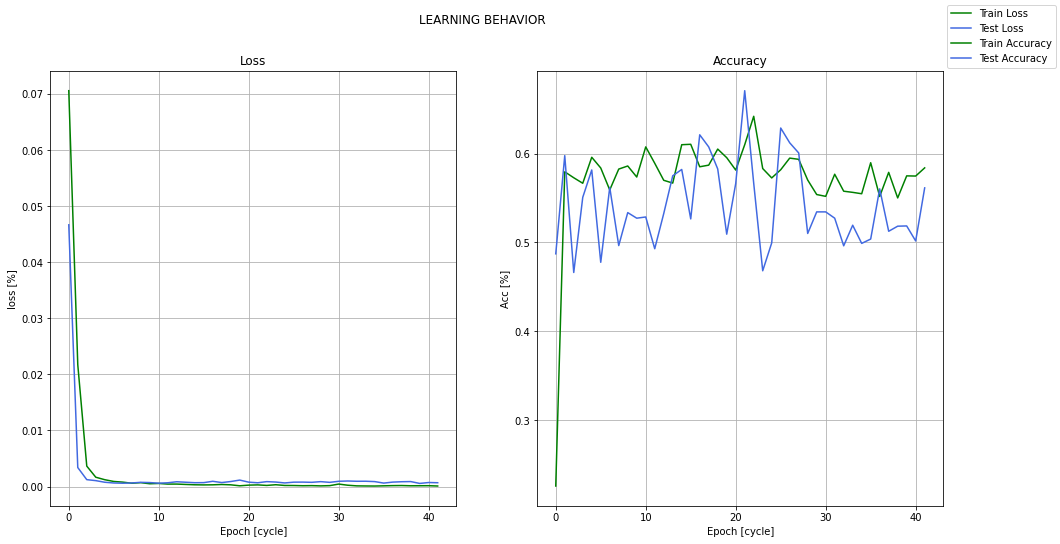

In [112]:
# reporting results
# reporte de entrenamiento para el modelo
# base de la figura
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# datos de la figura en de perdida y precision
ax1.plot(history_cnn.history["loss"], 'green', label = "Train Loss")
ax1.plot(history_cnn.history["val_loss"], 'royalblue', label = "Test Loss")
ax2.plot(history_cnn.history["accuracy"], 'green', label = "Train Accuracy")
ax2.plot(history_cnn.history["val_accuracy"], 'royalblue', label = "Test Accuracy")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

In [113]:
# saving image in png file
imgext = "jpg"
work_learn_img = model_fname + "-" + str_date + "-" + work_sufix + "-learn-curve." + imgext
img_fpn = os.path.join(root_folder, dataf, reportf, work_learn_img)
print(os.path.exists(img_fpn))
print(img_fpn)

False
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Reports\vvg_cnn_classifier-01-Jul-2021-Img-Data-Large-learn-curve.jpg


In [114]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)